In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 832)
(663976, 1)
validation
(128936, 832)
(128936, 1)
test
(61376, 832)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1542145 (5.88 MB)


Trainable params: 1542145 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:20 - loss: 0.2921 - STD: 1.0453e-04 - MAE: 0.5277

 5/67 [=>............................] - ETA: 1s - loss: 0.0982 - STD: 5.7297e-04 - MAE: 0.2429  

 8/67 [==>...........................] - ETA: 0s - loss: 0.0742 - STD: 3.9735e-04 - MAE: 0.2057

12/67 [====>.........................] - ETA: 0s - loss: 0.0634 - STD: 2.6980e-04 - MAE: 0.1931

15/67 [=====>........................] - ETA: 0s - loss: 0.0580 - STD: 2.1978e-04 - MAE: 0.1844

18/67 [=======>......................] - ETA: 0s - loss: 0.0527 - STD: 1.8884e-04 - MAE: 0.1724

22/67 [========>.....................] - ETA: 0s - loss: 0.0459 - STD: 1.6373e-04 - MAE: 0.1547

25/67 [==========>...................] - ETA: 0s - loss: 0.0424 - STD: 1.5044e-04 - MAE: 0.1482

29/67 [===========>..................] - ETA: 0s - loss: 0.0390 - STD: 1.3545e-04 - MAE: 0.1439

33/67 [=============>................] - ETA: 0s - loss: 0.0361 - STD: 1.2249e-04 - MAE: 0.1377

36/67 [===============>..............] - ETA: 0s - loss: 0.0342 - STD: 1.1389e-04 - MAE: 0.1322

39/67 [================>.............] - ETA: 0s - loss: 0.0327 - STD: 1.0622e-04 - MAE: 0.1273

42/67 [=================>............] - ETA: 0s - loss: 0.0317 - STD: 9.9706e-05 - MAE: 0.1231

45/67 [===================>..........] - ETA: 0s - loss: 0.0305 - STD: 9.4109e-05 - MAE: 0.1194

49/67 [====================>.........] - ETA: 0s - loss: 0.0291 - STD: 8.8017e-05 - MAE: 0.1157

52/67 [======================>.......] - ETA: 0s - loss: 0.0282 - STD: 8.3999e-05 - MAE: 0.1138

56/67 [========================>.....] - ETA: 0s - loss: 0.0272 - STD: 7.9429e-05 - MAE: 0.1117

60/67 [=========================>....] - ETA: 0s - loss: 0.0263 - STD: 7.5578e-05 - MAE: 0.1095

64/67 [===========================>..] - ETA: 0s - loss: 0.0255 - STD: 7.2064e-05 - MAE: 0.1073

67/67 [==============================] - 3s 34ms/step - loss: 0.0250 - STD: 6.9786e-05 - MAE: 0.1057 - val_loss: 0.0150 - val_STD: 1.5073e-05 - val_MAE: 0.0709


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0137 - STD: 2.1672e-05 - MAE: 0.0721

 4/67 [>.............................] - ETA: 1s - loss: 0.0137 - STD: 2.2483e-05 - MAE: 0.0732

 8/67 [==>...........................] - ETA: 0s - loss: 0.0138 - STD: 2.4270e-05 - MAE: 0.0752

12/67 [====>.........................] - ETA: 0s - loss: 0.0138 - STD: 2.5170e-05 - MAE: 0.0764

15/67 [=====>........................] - ETA: 0s - loss: 0.0138 - STD: 2.6245e-05 - MAE: 0.0764

18/67 [=======>......................] - ETA: 0s - loss: 0.0138 - STD: 2.6483e-05 - MAE: 0.0763

21/67 [========>.....................] - ETA: 0s - loss: 0.0138 - STD: 2.6769e-05 - MAE: 0.0760

24/67 [=========>....................] - ETA: 0s - loss: 0.0138 - STD: 2.7292e-05 - MAE: 0.0758

27/67 [===========>..................] - ETA: 0s - loss: 0.0137 - STD: 2.8068e-05 - MAE: 0.0758

30/67 [============>.................] - ETA: 0s - loss: 0.0138 - STD: 2.8703e-05 - MAE: 0.0758

33/67 [=============>................] - ETA: 0s - loss: 0.0138 - STD: 2.9367e-05 - MAE: 0.0759

36/67 [===============>..............] - ETA: 0s - loss: 0.0138 - STD: 3.0118e-05 - MAE: 0.0760

39/67 [================>.............] - ETA: 0s - loss: 0.0138 - STD: 3.1036e-05 - MAE: 0.0761

42/67 [=================>............] - ETA: 0s - loss: 0.0138 - STD: 3.1930e-05 - MAE: 0.0760

45/67 [===================>..........] - ETA: 0s - loss: 0.0138 - STD: 3.3033e-05 - MAE: 0.0760

49/67 [====================>.........] - ETA: 0s - loss: 0.0138 - STD: 3.4563e-05 - MAE: 0.0760

53/67 [======================>.......] - ETA: 0s - loss: 0.0138 - STD: 3.6121e-05 - MAE: 0.0759

56/67 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 3.7363e-05 - MAE: 0.0760

60/67 [=========================>....] - ETA: 0s - loss: 0.0138 - STD: 3.9069e-05 - MAE: 0.0759

63/67 [===========================>..] - ETA: 0s - loss: 0.0137 - STD: 4.0433e-05 - MAE: 0.0759

67/67 [==============================] - ETA: 0s - loss: 0.0137 - STD: 4.2501e-05 - MAE: 0.0758

67/67 [==============================] - 1s 20ms/step - loss: 0.0137 - STD: 4.2501e-05 - MAE: 0.0758 - val_loss: 0.0149 - val_STD: 5.6731e-05 - val_MAE: 0.0725


Epoch 3/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0139 - STD: 8.1188e-05 - MAE: 0.0756

 4/67 [>.............................] - ETA: 1s - loss: 0.0134 - STD: 8.3179e-05 - MAE: 0.0743

 8/67 [==>...........................] - ETA: 1s - loss: 0.0138 - STD: 8.8337e-05 - MAE: 0.0756

12/67 [====>.........................] - ETA: 0s - loss: 0.0139 - STD: 9.4042e-05 - MAE: 0.0762

16/67 [======>.......................] - ETA: 0s - loss: 0.0138 - STD: 9.9738e-05 - MAE: 0.0761

20/67 [=======>......................] - ETA: 0s - loss: 0.0137 - STD: 1.0565e-04 - MAE: 0.0758

23/67 [=========>....................] - ETA: 0s - loss: 0.0137 - STD: 1.1079e-04 - MAE: 0.0756

26/67 [==========>...................] - ETA: 0s - loss: 0.0137 - STD: 1.1630e-04 - MAE: 0.0755

29/67 [===========>..................] - ETA: 0s - loss: 0.0137 - STD: 1.2259e-04 - MAE: 0.0755

33/67 [=============>................] - ETA: 0s - loss: 0.0137 - STD: 1.3188e-04 - MAE: 0.0756

37/67 [===============>..............] - ETA: 0s - loss: 0.0137 - STD: 1.4219e-04 - MAE: 0.0757

41/67 [=================>............] - ETA: 0s - loss: 0.0137 - STD: 1.5353e-04 - MAE: 0.0756

44/67 [==================>...........] - ETA: 0s - loss: 0.0137 - STD: 1.6311e-04 - MAE: 0.0755

47/67 [====================>.........] - ETA: 0s - loss: 0.0137 - STD: 1.7387e-04 - MAE: 0.0755

50/67 [=====================>........] - ETA: 0s - loss: 0.0137 - STD: 1.8592e-04 - MAE: 0.0755

54/67 [=======================>......] - ETA: 0s - loss: 0.0137 - STD: 2.0457e-04 - MAE: 0.0755

58/67 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 2.2633e-04 - MAE: 0.0755

61/67 [==========================>...] - ETA: 0s - loss: 0.0137 - STD: 2.4505e-04 - MAE: 0.0755

65/67 [============================>.] - ETA: 0s - loss: 0.0137 - STD: 2.7403e-04 - MAE: 0.0756

67/67 [==============================] - 1s 20ms/step - loss: 0.0137 - STD: 2.9049e-04 - MAE: 0.0756 - val_loss: 0.0147 - val_STD: 6.2929e-04 - val_MAE: 0.0735


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0138 - STD: 8.8843e-04 - MAE: 0.0763

 5/67 [=>............................] - ETA: 1s - loss: 0.0139 - STD: 9.8212e-04 - MAE: 0.0763

 9/67 [===>..........................] - ETA: 0s - loss: 0.0138 - STD: 0.0011 - MAE: 0.0763    

12/67 [====>.........................] - ETA: 0s - loss: 0.0138 - STD: 0.0012 - MAE: 0.0760

16/67 [======>.......................] - ETA: 0s - loss: 0.0137 - STD: 0.0013 - MAE: 0.0757

20/67 [=======>......................] - ETA: 0s - loss: 0.0136 - STD: 0.0015 - MAE: 0.0753

23/67 [=========>....................] - ETA: 0s - loss: 0.0135 - STD: 0.0017 - MAE: 0.0751

27/67 [===========>..................] - ETA: 0s - loss: 0.0135 - STD: 0.0019 - MAE: 0.0750

30/67 [============>.................] - ETA: 0s - loss: 0.0135 - STD: 0.0021 - MAE: 0.0750

33/67 [=============>................] - ETA: 0s - loss: 0.0134 - STD: 0.0024 - MAE: 0.0749

36/67 [===============>..............] - ETA: 0s - loss: 0.0134 - STD: 0.0027 - MAE: 0.0748

40/67 [================>.............] - ETA: 0s - loss: 0.0133 - STD: 0.0031 - MAE: 0.0745

44/67 [==================>...........] - ETA: 0s - loss: 0.0132 - STD: 0.0037 - MAE: 0.0743

47/67 [====================>.........] - ETA: 0s - loss: 0.0132 - STD: 0.0043 - MAE: 0.0741

50/67 [=====================>........] - ETA: 0s - loss: 0.0130 - STD: 0.0049 - MAE: 0.0737

53/67 [======================>.......] - ETA: 0s - loss: 0.0129 - STD: 0.0056 - MAE: 0.0734

56/67 [========================>.....] - ETA: 0s - loss: 0.0128 - STD: 0.0064 - MAE: 0.0730

60/67 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 0.0077 - MAE: 0.0725

63/67 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 0.0089 - MAE: 0.0721

67/67 [==============================] - ETA: 0s - loss: 0.0123 - STD: 0.0106 - MAE: 0.0714

67/67 [==============================] - 1s 20ms/step - loss: 0.0123 - STD: 0.0106 - MAE: 0.0714 - val_loss: 0.0083 - val_STD: 0.0306 - val_MAE: 0.0539


Epoch 5/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0083 - STD: 0.0424 - MAE: 0.0589

 4/67 [>.............................] - ETA: 1s - loss: 0.0081 - STD: 0.0463 - MAE: 0.0582

 7/67 [==>...........................] - ETA: 1s - loss: 0.0078 - STD: 0.0498 - MAE: 0.0572

10/67 [===>..........................] - ETA: 0s - loss: 0.0075 - STD: 0.0530 - MAE: 0.0564

14/67 [=====>........................] - ETA: 0s - loss: 0.0072 - STD: 0.0571 - MAE: 0.0554

17/67 [======>.......................] - ETA: 0s - loss: 0.0071 - STD: 0.0598 - MAE: 0.0549

20/67 [=======>......................] - ETA: 0s - loss: 0.0069 - STD: 0.0620 - MAE: 0.0542

23/67 [=========>....................] - ETA: 0s - loss: 0.0067 - STD: 0.0642 - MAE: 0.0537

27/67 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0665 - MAE: 0.0531

31/67 [============>.................] - ETA: 0s - loss: 0.0064 - STD: 0.0686 - MAE: 0.0526

35/67 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0704 - MAE: 0.0521

39/67 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0720 - MAE: 0.0516

42/67 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0730 - MAE: 0.0513

45/67 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0741 - MAE: 0.0510

49/67 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0752 - MAE: 0.0507

53/67 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0763 - MAE: 0.0503

57/67 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0773 - MAE: 0.0500

61/67 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0782 - MAE: 0.0496

65/67 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0790 - MAE: 0.0493

67/67 [==============================] - 1s 20ms/step - loss: 0.0056 - STD: 0.0794 - MAE: 0.0492 - val_loss: 0.0032 - val_STD: 0.0775 - val_MAE: 0.0380


Epoch 6/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0917 - MAE: 0.0431

 4/67 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0924 - MAE: 0.0439

 8/67 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0925 - MAE: 0.0439

11/67 [===>..........................] - ETA: 0s - loss: 0.0043 - STD: 0.0936 - MAE: 0.0437

14/67 [=====>........................] - ETA: 0s - loss: 0.0042 - STD: 0.0938 - MAE: 0.0435

18/67 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0933 - MAE: 0.0432

21/67 [========>.....................] - ETA: 0s - loss: 0.0042 - STD: 0.0936 - MAE: 0.0432

25/67 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0933 - MAE: 0.0430

28/67 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0936 - MAE: 0.0429

31/67 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0938 - MAE: 0.0428

35/67 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0938 - MAE: 0.0425

38/67 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0939 - MAE: 0.0424

41/67 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0939 - MAE: 0.0422

44/67 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0941 - MAE: 0.0421

47/67 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0943 - MAE: 0.0419

51/67 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0944 - MAE: 0.0418

54/67 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0946 - MAE: 0.0417

57/67 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0947 - MAE: 0.0415

60/67 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0948 - MAE: 0.0414

63/67 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0949 - MAE: 0.0413

67/67 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0951 - MAE: 0.0412

67/67 [==============================] - 1s 20ms/step - loss: 0.0038 - STD: 0.0951 - MAE: 0.0412 - val_loss: 0.0034 - val_STD: 0.0841 - val_MAE: 0.0389


Epoch 7/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0386

 4/67 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0983 - MAE: 0.0385

 8/67 [==>...........................] - ETA: 0s - loss: 0.0034 - STD: 0.0981 - MAE: 0.0386

11/67 [===>..........................] - ETA: 0s - loss: 0.0034 - STD: 0.0979 - MAE: 0.0386

15/67 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0983 - MAE: 0.0388

19/67 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0984 - MAE: 0.0387

22/67 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0987 - MAE: 0.0387

26/67 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0987 - MAE: 0.0387

30/67 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0386

34/67 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0992 - MAE: 0.0386

37/67 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0388

41/67 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0389

44/67 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0988 - MAE: 0.0390

47/67 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0988 - MAE: 0.0390

51/67 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0390

54/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0391

57/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0390

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0989 - MAE: 0.0390

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0990 - MAE: 0.0390

67/67 [==============================] - 1s 20ms/step - loss: 0.0034 - STD: 0.0989 - MAE: 0.0390 - val_loss: 0.0034 - val_STD: 0.0860 - val_MAE: 0.0387


Epoch 8/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0967 - MAE: 0.0374

 4/67 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.1013 - MAE: 0.0379

 7/67 [==>...........................] - ETA: 1s - loss: 0.0032 - STD: 0.0995 - MAE: 0.0377

11/67 [===>..........................] - ETA: 0s - loss: 0.0032 - STD: 0.0994 - MAE: 0.0376

14/67 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0997 - MAE: 0.0376

18/67 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.1000 - MAE: 0.0376

21/67 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.1001 - MAE: 0.0377

25/67 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.1002 - MAE: 0.0375

29/67 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.1000 - MAE: 0.0375

32/67 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.1004 - MAE: 0.0375

35/67 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.1004 - MAE: 0.0375

38/67 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.1003 - MAE: 0.0374

41/67 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.1005 - MAE: 0.0374

44/67 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.1003 - MAE: 0.0374

48/67 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.1004 - MAE: 0.0374

51/67 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1005 - MAE: 0.0374

55/67 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.1005 - MAE: 0.0374

59/67 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.1007 - MAE: 0.0373

62/67 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.1006 - MAE: 0.0373

66/67 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.1008 - MAE: 0.0373

67/67 [==============================] - 1s 20ms/step - loss: 0.0031 - STD: 0.1008 - MAE: 0.0373 - val_loss: 0.0034 - val_STD: 0.0882 - val_MAE: 0.0383


Epoch 9/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0982 - MAE: 0.0366

 4/67 [>.............................] - ETA: 1s - loss: 0.0030 - STD: 0.1001 - MAE: 0.0365

 7/67 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1011 - MAE: 0.0367

10/67 [===>..........................] - ETA: 0s - loss: 0.0030 - STD: 0.1010 - MAE: 0.0367

14/67 [=====>........................] - ETA: 0s - loss: 0.0030 - STD: 0.1013 - MAE: 0.0367

17/67 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.1013 - MAE: 0.0367

21/67 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.1013 - MAE: 0.0366

24/67 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.1015 - MAE: 0.0366

27/67 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0365

30/67 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1016 - MAE: 0.0366

33/67 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0366

36/67 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0366

39/67 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0366

42/67 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0367

45/67 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0367

49/67 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1017 - MAE: 0.0366

52/67 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0366

56/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0366

60/67 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0366

63/67 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0367

67/67 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0366

67/67 [==============================] - 1s 20ms/step - loss: 0.0030 - STD: 0.1019 - MAE: 0.0366 - val_loss: 0.0037 - val_STD: 0.0932 - val_MAE: 0.0390


Epoch 10/10000


 1/67 [..............................] - ETA: 2s - loss: 0.0029 - STD: 0.1050 - MAE: 0.0359

 4/67 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1019 - MAE: 0.0362

 7/67 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1017 - MAE: 0.0361

11/67 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0362

14/67 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.1023 - MAE: 0.0362

17/67 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0362

20/67 [=======>......................] - ETA: 0s - loss: 0.0029 - STD: 0.1023 - MAE: 0.0361

23/67 [=========>....................] - ETA: 0s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0361

26/67 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0361

29/67 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1024 - MAE: 0.0360

32/67 [=============>................] - ETA: 0s - loss: 0.0029 - STD: 0.1025 - MAE: 0.0360

35/67 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0360

38/67 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0360

41/67 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0360

44/67 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0360

48/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0359

51/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0359

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0359

59/67 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1027 - MAE: 0.0359

62/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1026 - MAE: 0.0360

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0360

67/67 [==============================] - 1s 20ms/step - loss: 0.0029 - STD: 0.1027 - MAE: 0.0360 - val_loss: 0.0036 - val_STD: 0.0932 - val_MAE: 0.0384


Epoch 11/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1051 - MAE: 0.0363

 4/67 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0354

 7/67 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1038 - MAE: 0.0356

11/67 [===>..........................] - ETA: 0s - loss: 0.0029 - STD: 0.1041 - MAE: 0.0358

14/67 [=====>........................] - ETA: 0s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0358

17/67 [======>.......................] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0357

21/67 [========>.....................] - ETA: 0s - loss: 0.0029 - STD: 0.1037 - MAE: 0.0357

25/67 [==========>...................] - ETA: 0s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0357

29/67 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0357

33/67 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0356

36/67 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0356

39/67 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1031 - MAE: 0.0356

43/67 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1032 - MAE: 0.0356

46/67 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0357

50/67 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0357

54/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0357

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1032 - MAE: 0.0357

62/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0357

66/67 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1033 - MAE: 0.0357

67/67 [==============================] - 1s 19ms/step - loss: 0.0029 - STD: 0.1032 - MAE: 0.0357 - val_loss: 0.0036 - val_STD: 0.0947 - val_MAE: 0.0384


Epoch 12/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0354

 4/67 [>.............................] - ETA: 1s - loss: 0.0028 - STD: 0.1019 - MAE: 0.0353

 8/67 [==>...........................] - ETA: 1s - loss: 0.0028 - STD: 0.1026 - MAE: 0.0353

11/67 [===>..........................] - ETA: 0s - loss: 0.0028 - STD: 0.1019 - MAE: 0.0354

15/67 [=====>........................] - ETA: 0s - loss: 0.0028 - STD: 0.1028 - MAE: 0.0355

19/67 [=======>......................] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0355

23/67 [=========>....................] - ETA: 0s - loss: 0.0028 - STD: 0.1030 - MAE: 0.0355

26/67 [==========>...................] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0356

29/67 [===========>..................] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0356

32/67 [=============>................] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0355

36/67 [===============>..............] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0355

40/67 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0356

44/67 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.1034 - MAE: 0.0355

48/67 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.1033 - MAE: 0.0355

51/67 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355

55/67 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355

58/67 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355

62/67 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0355

65/67 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1036 - MAE: 0.0355

67/67 [==============================] - 1s 20ms/step - loss: 0.0028 - STD: 0.1035 - MAE: 0.0355 - val_loss: 0.0040 - val_STD: 0.0983 - val_MAE: 0.0402


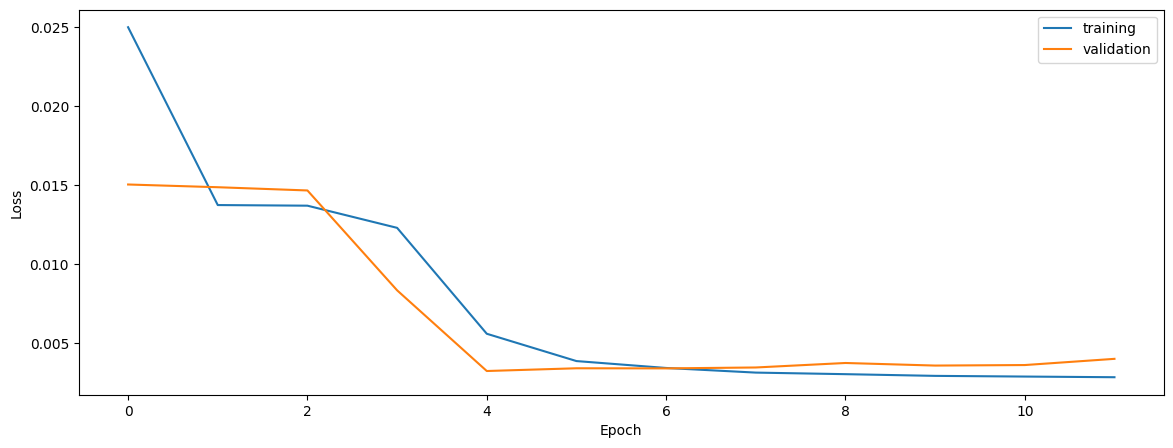

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8298142034386016
0.8869307762824273
0.7668034356649509


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8298142034386016
0.8869307762824273
0.7668034356649509


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8453962480414665
0.8956165663651217
0.7943347714533434


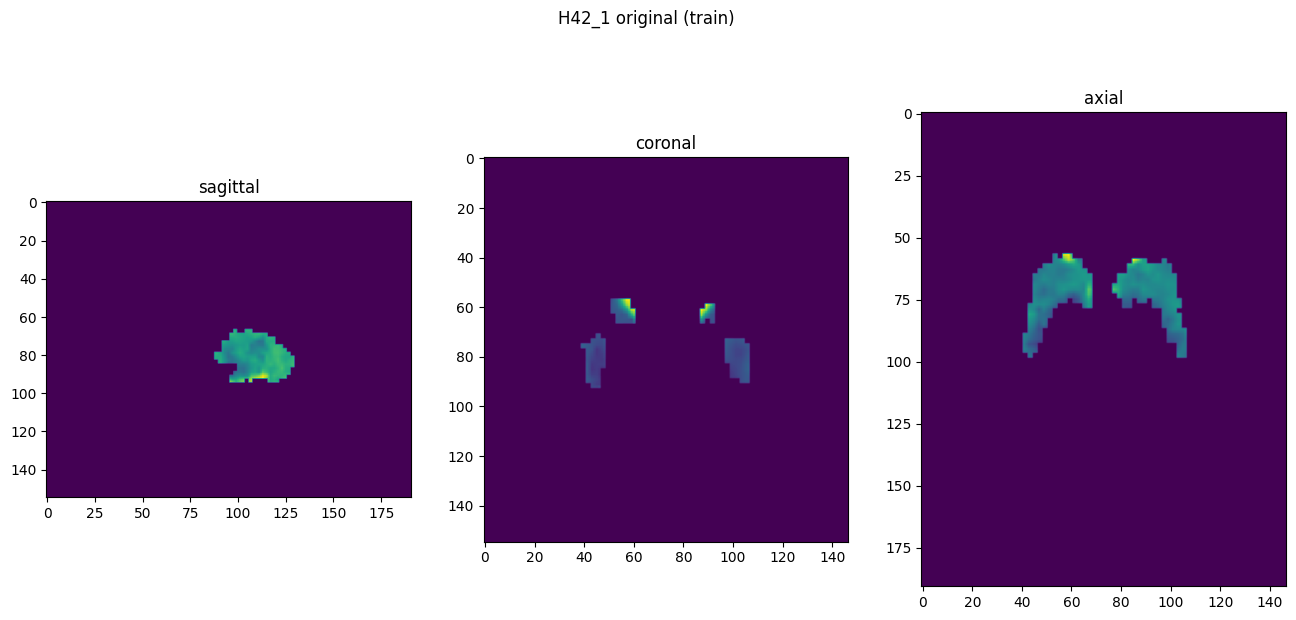

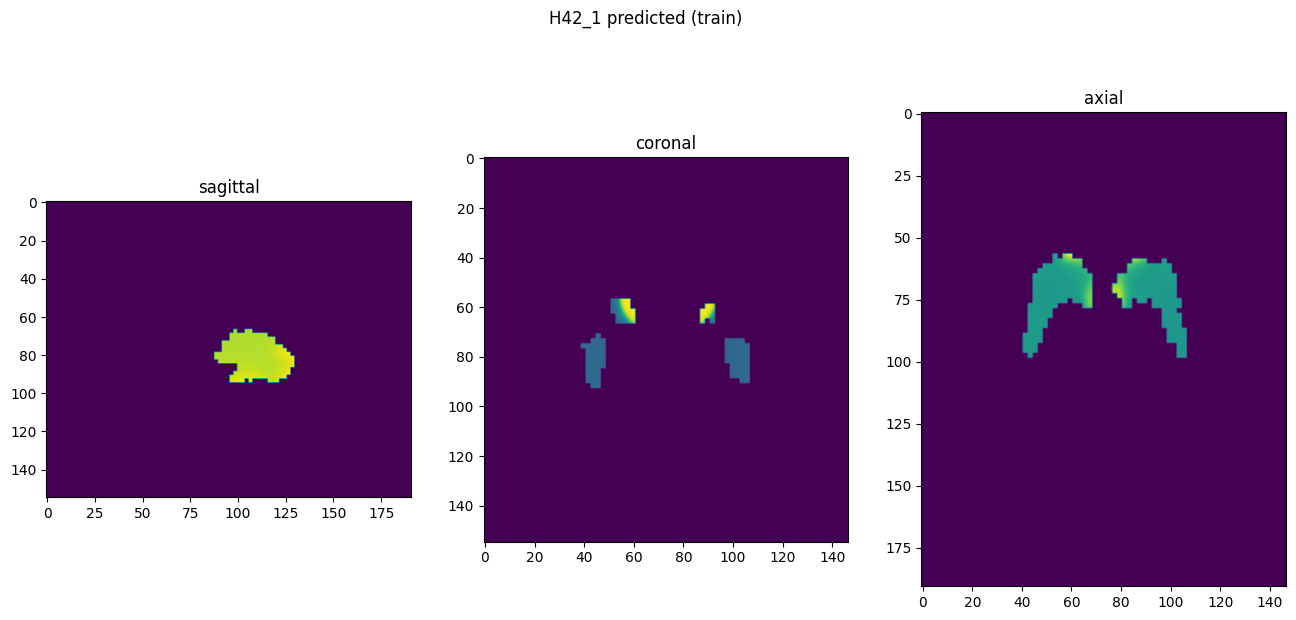

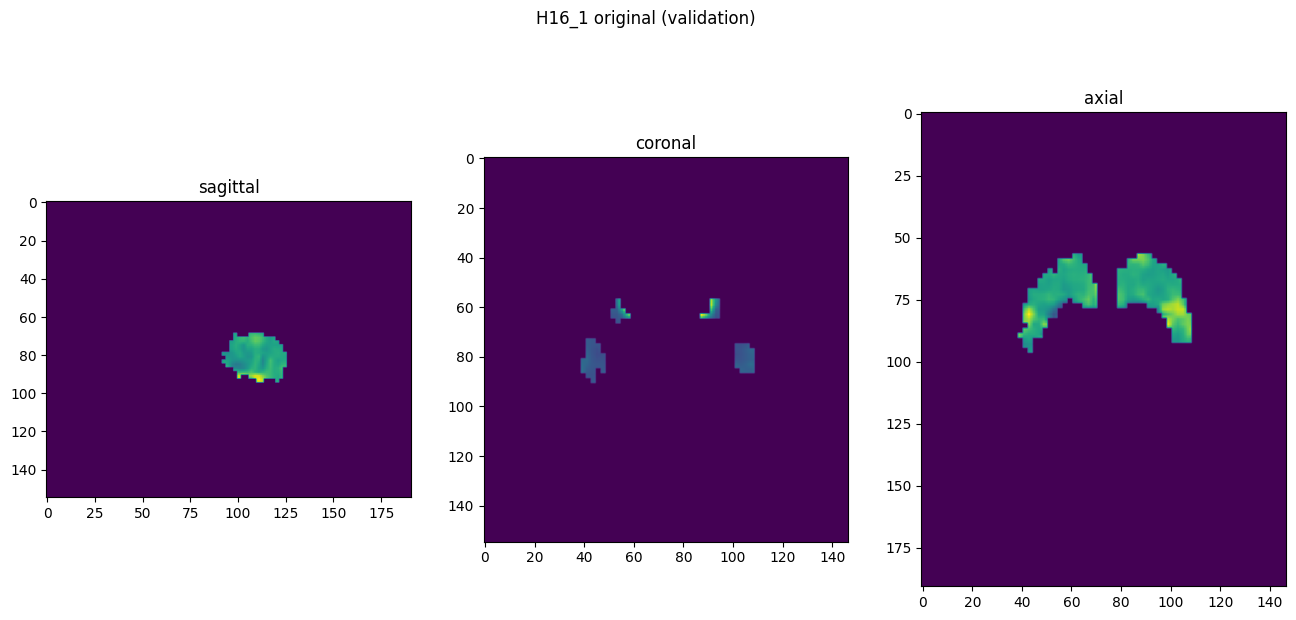

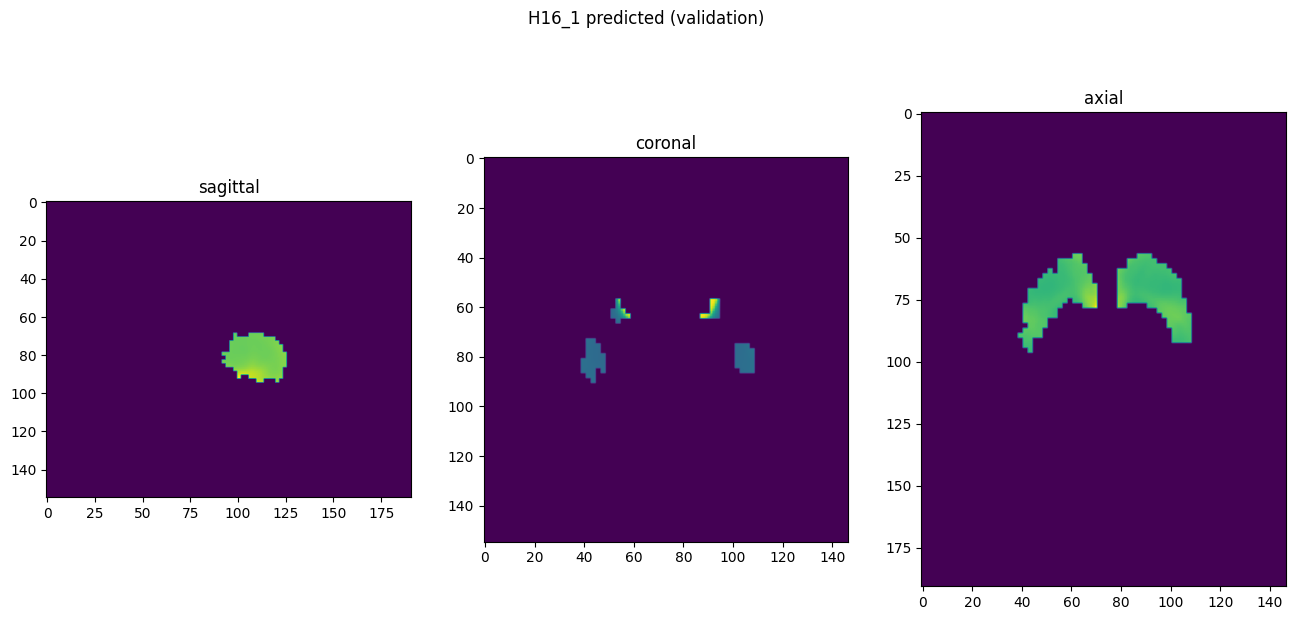

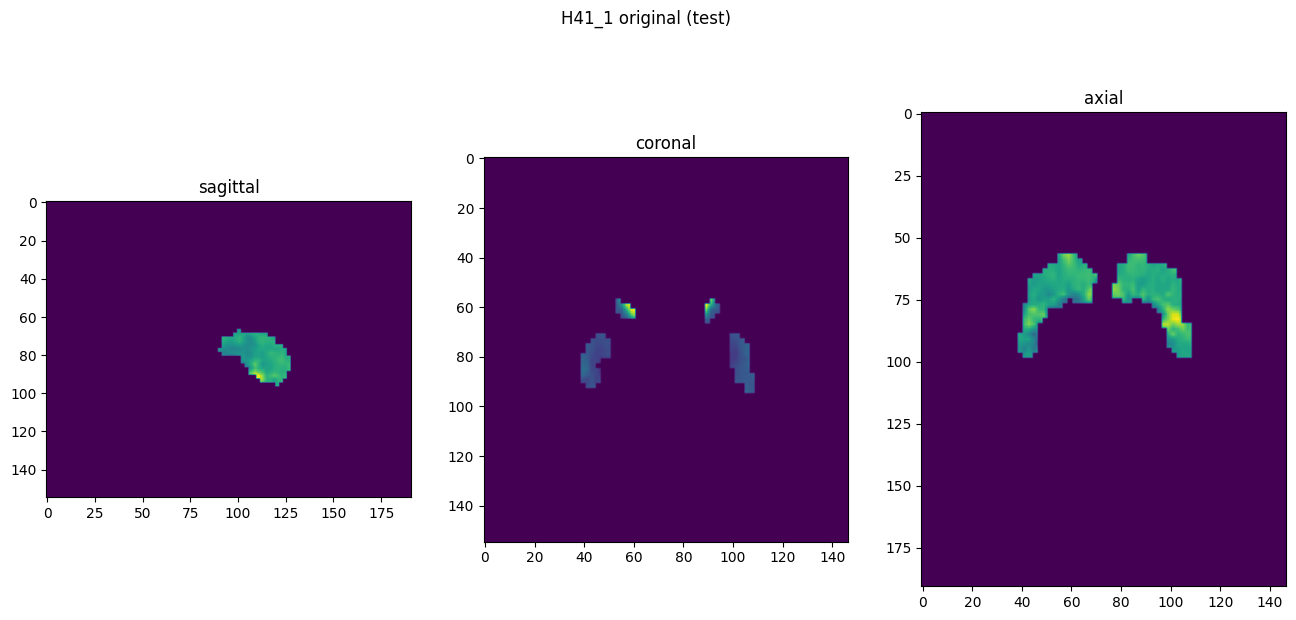

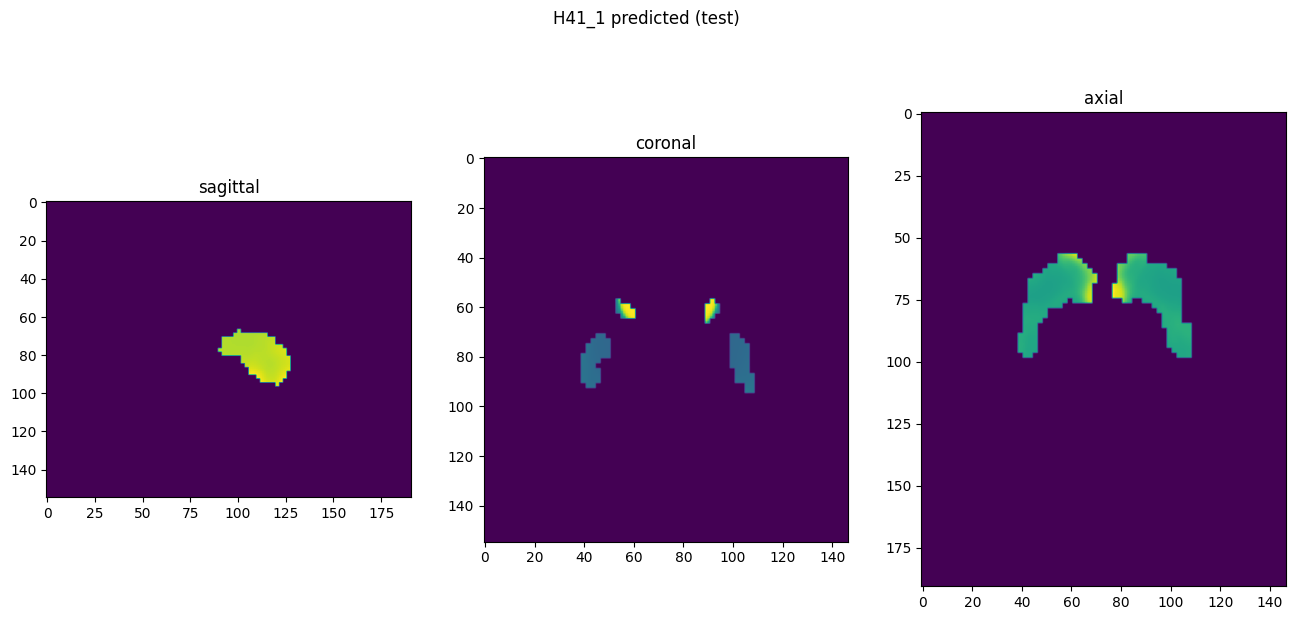

In [10]:
showResults(model, gen, threshold=None, background=False)